# JASCO
Welcome to JASCO's demo jupyter notebook. 
Here you will find a self-contained example of how to use JASCO for temporally controlled music generation.

You can choose a model from the following selection:
1. facebook/jasco-chords-drums-400M - 10s music generation conditioned on text, chords and drums, 400M parameters
2. facebook/jasco-chords-drums-1B - 10s music generation conditioned on text, chords and drums, 1B parameters


First, we start by initializing the JASCO model:

In [1]:
import os 
from finetuning_audiocraft.audiocraft.audiocraft import JASCO

chords_mapping_path = os.path.abspath('assets/chord_to_index_mapping.pkl')
model = JASCO.get_pretrained('facebook/jasco-chords-drums-1B', chords_mapping_path='assets/chord_to_index_mapping.pkl')


/private/home/ortal1/miniconda3/envs/jasco_dev/lib/python3.9/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/private/home/ortal1/miniconda3/envs/jasco_dev/lib/python3.9/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/private/home/ortal1/miniconda3/envs/jasco_dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, let us configure the generation parameters. Specifically, you can control the following:
* `cfg_coef_all` (float, optional): Coefficient used for classifier free guidance - fully conditional term. 
                                    Defaults to 5.0.
* `cfg_coef_txt` (float, optional): Coefficient used for classifier free guidance - additional text conditional term. 
                                    Defaults to 0.0.

When left unchanged, JASCO will revert to its default parameters.

In [13]:
model.set_generation_params(
    cfg_coef_all=0.0,
    cfg_coef_txt=5.0
)

Next, we can go ahead and start generating music given textual prompts.

### Text-conditional Generation

In [ ]:
from finetuning_audiocraft.audiocraft.audiocraft.utils.notebook import display_audio

# set textual prompt
text = "Funky groove with electric piano playing blue chords rhythmically"

# run the model
print("Generating...")              
output = model.generate(descriptions=[text], progress=True)

# display the result
print(f"Text: {text}\n")
display_audio(output, sample_rate=model.compression_model.sample_rate)

Now we can start adding temporal controls! We begin with conditioning on chord progressions:

### Chords-conditional Generation

In [ ]:
from finetuning_audiocraft.audiocraft.audiocraft.utils.notebook import display_audio

model.set_generation_params(
    cfg_coef_all=1.5,
    cfg_coef_txt=2.5
)

# set textual prompt
text = "Strings, woodwind, orchestral, symphony."

# define chord progression
chords = [('C', 0.0), ('D', 2.0), ('F', 4.0), ('Ab', 6.0), ('Bb', 7.0), ('C', 8.0)]

# run the model
print("Generating...")
output = model.generate_music(descriptions=[text], chords=chords, progress=True)

# display the result
print(f'Text: {text}')
print(f'Chord progression: {chords}')
display_audio(output, sample_rate=model.compression_model.sample_rate)

Next, we can condition the generation on drum tracks:

### Drums-conditional Generation

In [ ]:
import torchaudio
from finetuning_audiocraft.audiocraft.audiocraft.utils.notebook import display_audio


# load drum prompt
drums_waveform, sr = torchaudio.load("./assets/sep_drums_1.mp3")

# set textual prompt 
text = "distortion guitars, heavy rock, catchy beat"

# run the model
print("Generating...")
output = model.generate_music(
    descriptions=[text],
    drums_wav=drums_waveform,
    drums_sample_rate=sr,
    progress=True
)

# display the result
print('drum prompt:')
display_audio(drums_waveform, sample_rate=sr)
print(f'Text: {text}')
display_audio(output, sample_rate=model.compression_model.sample_rate)

We can also combine multiple temporal controls! Let's move on to generating with both chords and drums conditioning:

### Drums + Chords conditioning

In [ ]:
import torchaudio
from finetuning_audiocraft.audiocraft.audiocraft.utils.notebook import display_audio


# load drum prompt
drums_waveform, sr = torchaudio.load("./assets/sep_drums_1.mp3")

# set textual prompt 
text = "string quartet, orchestral, dramatic"

# define chord progression
chords = [('C', 0.0), ('D', 2.0), ('F', 4.0), ('Ab', 6.0), ('Bb', 7.0), ('C', 8.0)]

# run the model
print("Generating...")
output = model.generate_music(
    descriptions=[text],
    drums_wav=drums_waveform,
    drums_sample_rate=sr,
    chords=chords,
    progress=True
)

# display the result
print('drum prompt:')
display_audio(drums_waveform, sample_rate=sr)
print(f'Chord progression: {chords}')
print(f'Text: {text}')
display_audio(output, sample_rate=model.compression_model.sample_rate)

### Melody + Drums + Chords conditioning - inference example

Source melody:


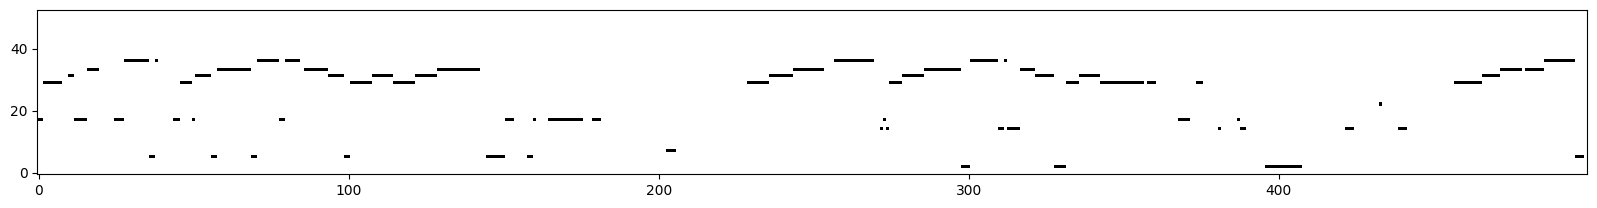

Chords:
[('N', 0.0), ('C', 0.32), ('Dm7', 3.456), ('Am', 4.608), ('F', 8.32), ('C', 9.216)]


Separated drums:


Generating...


In [3]:
%matplotlib inline
import torchaudio
from demucs import pretrained
from demucs.apply import apply_model
from demucs.audio import convert_audio
import torch
from finetuning_audiocraft.audiocraft.audiocraft.utils.notebook import display_audio
import matplotlib.pyplot as plt

# --------------------------
# First, choose file to load
# --------------------------
fnames = ['salience_1', 'salience_2']
chords = [
    [('N',  0.0), ('Eb7',  1.088000000), ('C#',  4.352000000), ('D',  4.864000000), ('Dm7',  6.720000000), ('G7',  8.256000000), ('Am7b5/G',  9.152000000)],  # for salience 1
    [('N',  0.0), ('C',  0.320000000), ('Dm7',  3.456000000), ('Am',  4.608000000), ('F',  8.320000000), ('C',  9.216000000)]  # for salience 2
]
file_idx = 1  # either 0 or 1


# ------------------------------------
# display audio, melody map and chords
# ------------------------------------
def plot_chromagram(tensor):
    # Check if tensor is a PyTorch tensor
    if not torch.is_tensor(tensor):
        raise ValueError('Input should be a PyTorch tensor')
    tensor = tensor.numpy().T # C, T
    plt.figure(figsize=(20, 20))
    plt.imshow(tensor, cmap='binary', interpolation='nearest', origin='lower')
    plt.show()

# load salience and display the corresponding wav
melody_prompt_wav, melody_prompt_sr = torchaudio.load(f"./assets/{fnames[file_idx]}.wav")
print("Source melody:")
display_audio(melody_prompt_wav, sample_rate=melody_prompt_sr)
melody =  torch.load(f"./assets/{fnames[file_idx]}.th", weights_only=True)
plot_chromagram(melody)
print("Chords:")
print(chords[file_idx])

# --------------------------------------------------
# use demucs to seperate the drums stem from src mix
# --------------------------------------------------
def _get_drums_stem(wav: torch.Tensor, sample_rate: int) -> torch.Tensor:
    """Get parts of the wav that holds the drums, extracting the main stems from the wav."""
    demucs_model = pretrained.get_model('htdemucs').to('cuda')
    wav = convert_audio(
        wav, sample_rate, demucs_model.samplerate, demucs_model.audio_channels)  # type: ignore
    stems = apply_model(demucs_model, wav.cuda().unsqueeze(0), device='cuda').squeeze(0)
    drum_stem = stems[demucs_model.sources.index('drums')]  # extract relevant stems for drums conditioning
    return convert_audio(drum_stem.cpu(), demucs_model.samplerate, sample_rate, 1)  # type: ignore
drums_wav = _get_drums_stem(melody_prompt_wav, melody_prompt_sr)
print("Separated drums:")
display_audio(drums_wav, sample_rate=melody_prompt_sr)

# ----------------------------------
# Generate using the loaded controls
# ----------------------------------
# these are free-form texts written randomly
texts = [
    '90s rock with heavy drums and hammond',
    '80s pop with groovy synth bass and drum machine',
    'folk song with leading accordion',
]

print("Generating...")
# replacing dynammic solver with simple euler solver
model.set_generation_params(cfg_coef_all=1.5, cfg_coef_txt=2.5, euler=True, euler_steps=50)  # manually set with euler solver
output = model.generate_music(
    descriptions=texts,
    chords=chords[file_idx],
    drums_wav=drums_wav,
    drums_sample_rate=melody_prompt_sr,
    melody_salience_matrix=melody.permute(1, 0),
    progress=True
)
display_audio(output, sample_rate=model.compression_model.sample_rate)